### Compute Mean-Flux as function of redshift

In order to ensure that the overall $\delta_F$ level is zero...

The pixel data needs to be generated using the IDL script GEN_CROSSCORR_INPUT.PRO

RA limits are 149.87192 150.44998
Dec limits are 2.07213 2.49511
Read in 95748 Ly-a forest pixels


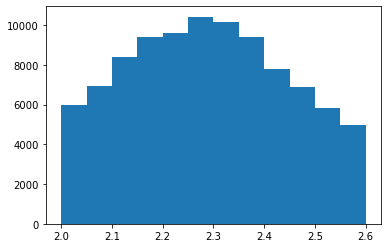

In [1]:
import numpy as np
import time as time
import os
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
# %config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
# %matplotlib notebook

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

def taueff_evo(z):
    return 0.001845 * (1.+z)**3.924

def var_lyaf(z):
    return 0.065* ((1.+z)/3.25)**3.8

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

base_path = "data/clamato_dr2"
    
lyapix = xcorr.lyapix(os.path.join(base_path, "pixel_radecz_cl2020_v0.bin"),cosmo=cosmo)


print("Read in %i Ly-a forest pixels" % lyapix.npix)
npix = lyapix.npix

fig, ax = plt.subplots()
binwidth = 0.05
histdata = lyapix.z

ax.hist(histdata,bins=np.arange(min(histdata),max(histdata) + binwidth, binwidth))
plt.show()

Carry out mean-flux calculation... begin by converting the deltas and sigmas back to $F$ basis

/global/homes/b/bzh/.conda/envs/clamato-xcorr/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


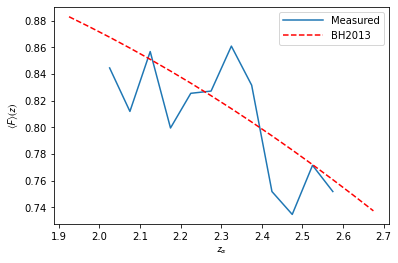

In [2]:
zmax = 2.7
zmin = 1.9
dzbin = 0.05

# Convert delta_F back to F
Fvec = (1. + lyapix.delta)*np.exp(-taueff_evo(lyapix.z))

# generate the weight vectors
w_F = lyapix.w / np.exp(-2. * taueff_evo(lyapix.z))

nbin = round((zmax - zmin)/dzbin)
zbins = np.arange(zmin, zmax-dzbin, dzbin)
Fmeas = np.empty(nbin)

for ii in range(0, nbin):
    zlower = zbins[ii]
    zupper = zlower + dzbin
    grabpix = np.all(np.column_stack([(lyapix.z >= zlower),(lyapix.z<zupper)]), axis=1)
    Fmeas[ii] = np.sum(w_F[grabpix]*Fvec[grabpix])/np.sum(w_F[grabpix])

    
fig, ax = plt.subplots()
ax.plot(zbins+dzbin/2., Fmeas, label='Measured')
ax.plot(zbins+dzbin/2., np.exp(-taueff_evo(zbins+dzbin/2.)), color='r',
        linestyle='--', label='BH2013')
ax.set_xlabel(r'$z_{\alpha}$')
ax.set_ylabel(r'$\langle F \rangle (z)$')

plt.legend(loc='upper right',handlelength=4)

plt.show()

ascii.write([zbins+dzbin/2., Fmeas], os.path.join(base_path, 'fmean_measured_v0.dat'), names=['zmid', 'F_mean'])